In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Interacting with the NEC5 Design in Python
Use Python control loops to interact with your antenna design.

In [15]:
from necutil import nec5_sim_stdio3, plot_vswr, plot_azimuth2, plot_elevation, ft2m
import numpy as np

# Python f-strings are handy to deal with computed values
flow, fhigh = (14.0, 15.0)          # Band of interest, MHz
nfreq = 101                          # Number of freqs to compute Z at (10 kHz steps in this case)
dipole_len = ft2m( 468.0 / np.mean((flow,fhigh)) )     # Dipole length, meters
necdeck = '\n'.join(
    ['CE Dipole',               # Comment
     f'GW 1 20 0 -{dipole_len/2} 20 0 {dipole_len/2} 20 .001',   # Wire element, 20 segments, from (0,-5.06,20) to (0,5.06,20)  (lengths in meters)
     'GE 1 0',                  # End of geometry; ground plane specified
     'GD 0 0 0 0 13 0.005 0 0', # Some typical MININEC ground parameters
     'EX 4 1 10 2 1.0 0.0',     # Excitation: current source (1A), tag=1, segment=10, far end=2
     f'FR 0 {nfreq} 0 0 {flow} {(fhigh-flow)/(nfreq-1)}',    # Frequencies for XQ card: 14.0 - 15.0 MHz
     'XQ 0',                    # Simulate feedpoint impedance
     'EN\n'                     # End
    ])

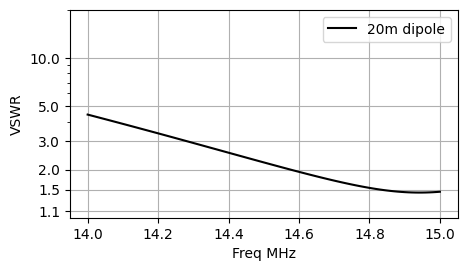

In [16]:
# Run the simulation
result = nec5_sim_stdio3([necdeck])

# Display VSWR with 50ohm transmission line
plot_vswr(result[0][0], ['20m dipole'])


# Iterating over values with Python
### Visualize VSWR for multiple antenna lengths.

In [69]:
# Use format() to interact with the antenna design
necdeck = '\n'.join(
    ['CE Dipole',               # Comment
     'GW 1 20 0 -{y} {z} 0 {y} {z} .001',   # Wire element, 20 segments, from (0,-5.06,20) to (0,5.06,20)  (lengths in meters)
     'GE 1 0',                  # End of geometry; ground plane specified
     'GD 0 0 0 0 13 0.005 0 0', # Some typical MININEC ground parameters
     'EX 4 1 10 2 1.0 0.0',     # Excitation: current source (1A), tag=1, segment=10, far end=2
     'FR 0 11 0 0 14.0 0.1',    # Frequencies for XQ card: 14.0 - 15.0 MHz
     'XQ 0',                    # Simulate feedpoint impedance
     'FR 0 1 0 0 14.2 0',       # Frequency for RP card: 14.2 MHz
     'RP 0 91 361 0000 0 0 1 1',    # Simulate radiation pattern on 1deg grid
    'EN\n'                     # End
    ])


# Create a list of designs using a list comprehension
lengths = [10.2,10.3,10.4,10.5] # Dipole length (m)
designs = [necdeck.format(y=ln/2, z=20) for ln in lengths]

# .. and run the simulations in parallel
results = nec5_sim_stdio3(designs)



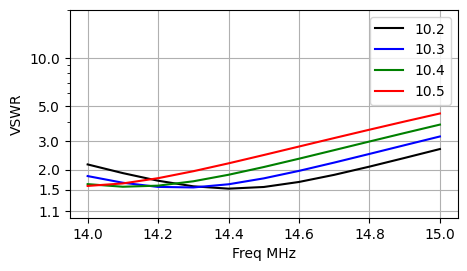

In [70]:
zcurves = [res[0][0] for res in results]


# [[[14.0, (72.329-41.725j)],
#   [14.1, (73.239-32.024j)],
#   [14.2, (74.125-22.285j)],
#   [14.3, (74.992-12.503j)],
#   ...

plot_vswr(zcurves, lengths)


### Plot relationship of antenna height and elevation of peak response

In [93]:
# Create a list of designs using a list comprehension
zs = [5,10,20,30,50,70,100]                                 # Antenna heights
designs = [necdeck.format(z=z, y=10.3/2) for z in zs]       # Fixed dipole length of 10.3m

# .. and run the simulations in parallel
results = nec5_sim_stdio3(designs)

In [94]:
# Extract a list of elevations of peak response
elevs = []
for res in results:                     # Loop through corresponding results for our list of designs
    rp = res[1][0][0][1]                # Rad pat array for this design (see later notebooks for more details)
    rp0 = rp[rp[:,1]==0.0]              # Select only rows with azimuth=0
    idx = np.argmax(rp0[:,2])           # Get index of row with highest response
    elevs.append(90.0 - rp[idx, 0])     #  and get corresponding elevation (= 90 - phi)

# 'rp' is a numpy array that looks like:
#           phi     theta       dBi     theta=azimuth, phi=angle from vertical (not horizon)
# array([[   0.  ,    0.  ,    6.21],
#        [   1.  ,    0.  ,    6.21],
#        [   2.  ,    0.  ,    6.2 ],
#        ...,
#        [  88.  ,  360.  ,    6.82],
#        [  89.  ,  360.  ,    2.08],
#        [  90.  ,  360.  , -999.99]])


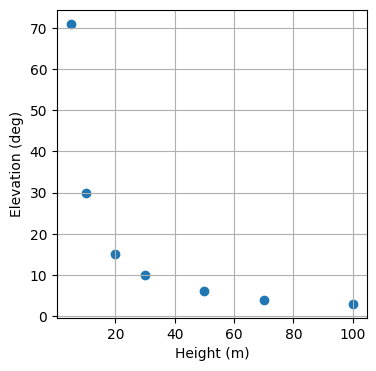

In [95]:
# Standard matplotlib scatter plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(zs, elevs)
ax.set_xlabel('Height (m)')
ax.set_ylabel('Elevation (deg)')
ax.grid(True)

